# **CSAI ASSIGNMENT 3**
# Srujana Vanka - 2020102005

In [ ]:
!pip install --upgrade matplotlib
!pip install --upgrade pip
!pip install sentence-transformers


# Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt                       # Matplotlib to plot the outputs 
from sentence_transformers import SentenceTransformer
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_distances
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from tqdm import tqdm
os.environ['TOKENIZERS_PARALLELISM'] = '0'
from scipy import stats
import warnings                                        # Ignore warnings in output
warnings.simplefilter("ignore") 

In [3]:
# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

# Load stimuli
with open('stimuli.txt','r') as f:
    stimuli = f.readlines()
for i in range(len(stimuli)):
    stimuli[i] = stimuli[i].strip()

# Get BERT CLS embeddings
bert_cls_embeddings = []
for sentence in stimuli:
    input_ids = torch.tensor(tokenizer.encode(sentence, add_special_tokens=True)).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        hidden_states = outputs[2]
        cls_embedding = hidden_states[-1][0][0] # get the last layer, the first token, which is [CLS]
        bert_cls_embeddings.append(cls_embedding.numpy())
bert_cls_embeddings = np.array(bert_cls_embeddings)

# Get BERT pooled embeddings
bert_pooled_embeddings = []
for sentence in stimuli:
    input_ids = torch.tensor(tokenizer.encode(sentence, add_special_tokens=True)).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        pooled_embedding = outputs[1][0] # get the pooled output
        bert_pooled_embeddings.append(pooled_embedding.numpy())
bert_pooled_embeddings = np.array(bert_pooled_embeddings)

# Encode sentences using sentence transformer model
model = SentenceTransformer('sentence-transformers/stsb-bert-large')
stimuli_encoded = model.encode(stimuli)

# Load GloVe embeddings
glove_embeddings = {}
with open('glove.6B.300d.txt', 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs

glove_dim = len(next(iter(glove_embeddings.values())))
glove_embeddings_matrix = np.zeros((len(stimuli), glove_dim))
for i, sentence in enumerate(stimuli):
    sentence_embedding = np.mean([glove_embeddings.get(token, np.zeros(glove_dim)) for token in sentence.split()], axis=0)
    glove_embeddings_matrix[i] = sentence_embedding


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Evaluation metrics 

### 2v2 accuracy metric

In [4]:
# 2V2 Accuracy - using cosine distance function
def evalmetric_2v2(y_true, y_pred):
    cs_dist = cosine_distances(y_true, y_pred)
    value = 0
    # 𝐼[𝑐] is an indicator function such that 𝐼[𝑐] = 1 if 𝑐 is true, else it is 0
    for i in range(len(y_true) - 1):
        for j in range(i + 1, len(y_true)):
            a, b = cs_dist[i, i] + cs_dist[j, j], cs_dist[i, j] + cs_dist[j, i]
            value += 1 if a < b else 0
    return value / (len(y_true) * (len(y_true) - 1) / 2)

### Pearson Correlation metric

In [5]:
# Pearson Correlation (PC) - a measure of linear correlation between two sets of data
def evalmetric_pc(y_true, y_pred):
    # 1/N * (sum of the prearson correlation coefficients)
    return np.mean([np.corrcoef(y_t, y_p)[0][1] for y_t, y_p in zip(y_true, y_pred)])

# Brain decoder
### To build 4 different decoders one for each brain ROI
The decoder is a regression based model like ridge regression. Performing a k-fold cross validation, and reporting the average of the evaluation
metrics across folds.

In [6]:
def decode(num, scorer_type, emb, cv=3, reg_type='ridge'):
    # num: dataset subject num
    # score_type: metric - 2v2 or pc
    # k: cross-validation k

    datasub = np.load(f"subj{num}.npy", allow_pickle=True).item()
    scorer_func = evalmetric_2v2 if scorer_type == '2v2' else evalmetric_pc
    scorer = make_scorer(scorer_func, greater_is_better=True) 

    if reg_type == 'lasso':
        regressor = linear_model.Lasso()
    else:
        regressor = linear_model.Ridge()

    score_dic_d = {}
    if emb == 'bert_cls':
        y = bert_cls_embeddings.reshape(len(stimuli), -1)
    if emb == 'glove':
        y = glove_embeddings_matrix
    if emb == 'bert_pooled':
        y = bert_pooled_embeddings.reshape(len(stimuli), -1)
    for k, X in tqdm(datasub.items()):
        scores = cross_val_score(regressor, X, y, cv=cv, scoring=scorer, n_jobs=-1)
        score_dic_d[k] = np.mean(scores)
        print(f"Subject {k}: Mean cross-validation score = {score_dic_d[k]:.4f}")

    mean_acc = np.mean(list(score_dic_d.values()))
    print(f"Mean accuracy across all subjects = {mean_acc:.4f}")

    return score_dic_d

# Brain Encoder
### To build 4 different encoders one for each brain area
Similar to the decoder, the encoder is a regression based model like ridge regression. Performing a k-fold cross validation, and reporting the average of the evaluation
metrics across folds.

In [7]:
def encode(num, scorer_type, emb, cv=3, reg_type='ridge'):
    # num: dataset subject num
    # score_type: metric - 2v2 or pc
    # k: cross-validation k

    datasub = np.load(f"subj{num}.npy", allow_pickle=True).item()
    scorer_func = evalmetric_2v2 if scorer_type == '2v2' else evalmetric_pc
    scorer = make_scorer(scorer_func, greater_is_better=True) 

    if reg_type == 'lasso':
        regressor = linear_model.Lasso()
    else:
        regressor = linear_model.Ridge()

    score_dic_e = {}
    if emb == 'bert_cls':
        y = np.array(bert_cls_embeddings).reshape(len(stimuli), -1)
    if emb == 'glove':
        y = glove_embeddings_matrix
    if emb == 'bert_pooled':
        y = np.array(bert_pooled_embeddings)

    for k, X in tqdm(datasub.items()):
        scores = cross_val_score(regressor, y, X, cv=cv, scoring=scorer, n_jobs=-1)
        score_dic_e[k] = np.mean(scores)
        print(f"Subject {k}: Mean cross-validation score = {score_dic_e[k]:.4f}")

    mean_acc = np.mean(list(score_dic_e.values()))
    print(f"Mean accuracy across all subjects = {mean_acc:.4f}")

    return score_dic_e


In [9]:
# Subject 1 - glove embeddings
# 2v2 metric
score_dic_d_g = decode(1,'2v2', 'glove')
score_dic_e_g = encode(1,'2v2', 'glove')

# PC metric
score_dic_d_p_g = decode(1,'pc', 'glove')
score_dic_e_p_g = encode(1,'pc', 'glove')


 25%|██▌       | 1/4 [00:00<00:02,  1.49it/s]

Subject language: Mean cross-validation score = 0.8906


 50%|█████     | 2/4 [00:02<00:02,  1.21s/it]

Subject vision: Mean cross-validation score = 0.8853


 75%|███████▌  | 3/4 [00:03<00:01,  1.08s/it]

Subject dmn: Mean cross-validation score = 0.8381


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

Subject task: Mean cross-validation score = 0.8446
Mean accuracy across all subjects = 0.8646



 25%|██▌       | 1/4 [00:00<00:01,  1.73it/s]

Subject language: Mean cross-validation score = 0.7475


 50%|█████     | 2/4 [00:02<00:02,  1.23s/it]

Subject vision: Mean cross-validation score = 0.7340


 75%|███████▌  | 3/4 [00:03<00:01,  1.09s/it]

Subject dmn: Mean cross-validation score = 0.6524


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]

Subject task: Mean cross-validation score = 0.6764
Mean accuracy across all subjects = 0.7026



 25%|██▌       | 1/4 [00:00<00:01,  2.34it/s]

Subject language: Mean cross-validation score = 0.7681


 50%|█████     | 2/4 [00:01<00:01,  1.14it/s]

Subject vision: Mean cross-validation score = 0.7752


 75%|███████▌  | 3/4 [00:02<00:00,  1.08it/s]

Subject dmn: Mean cross-validation score = 0.7711


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]

Subject task: Mean cross-validation score = 0.7912
Mean accuracy across all subjects = 0.7764



 25%|██▌       | 1/4 [00:03<00:09,  3.19s/it]

Subject language: Mean cross-validation score = 0.7217


 50%|█████     | 2/4 [00:10<00:10,  5.42s/it]

Subject vision: Mean cross-validation score = 0.7669


 75%|███████▌  | 3/4 [00:13<00:04,  4.55s/it]

Subject dmn: Mean cross-validation score = 0.4946


100%|██████████| 4/4 [00:20<00:00,  5.18s/it]

Subject task: Mean cross-validation score = 0.5155
Mean accuracy across all subjects = 0.6247


In [11]:
# Subject 1 - bert cls embeddings
# 2v2 metric
score_dic_d_cls = decode(1,'2v2', 'bert_cls')
score_dic_e_cls = encode(1,'2v2', 'bert_cls')

# PC metric
score_dic_d_p_cls = decode(1,'pc', 'bert_cls')
score_dic_e_p_cls = encode(1,'pc', 'bert_cls')

 25%|██▌       | 1/4 [00:00<00:01,  1.82it/s]

Subject language: Mean cross-validation score = 0.8444


 50%|█████     | 2/4 [00:01<00:01,  1.01it/s]

Subject vision: Mean cross-validation score = 0.8339


 75%|███████▌  | 3/4 [00:02<00:00,  1.09it/s]

Subject dmn: Mean cross-validation score = 0.8130


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Subject task: Mean cross-validation score = 0.8124
Mean accuracy across all subjects = 0.8259


 25%|██▌       | 1/4 [00:00<00:01,  1.91it/s]

Subject language: Mean cross-validation score = 0.6701


 50%|█████     | 2/4 [00:01<00:01,  1.02it/s]

Subject vision: Mean cross-validation score = 0.6584


 75%|███████▌  | 3/4 [00:02<00:00,  1.19it/s]

Subject dmn: Mean cross-validation score = 0.5933


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Subject task: Mean cross-validation score = 0.5982
Mean accuracy across all subjects = 0.6300


 25%|██▌       | 1/4 [00:00<00:01,  2.00it/s]

Subject language: Mean cross-validation score = 0.8087


 50%|█████     | 2/4 [00:01<00:01,  1.00it/s]

Subject vision: Mean cross-validation score = 0.8152


 75%|███████▌  | 3/4 [00:02<00:00,  1.16it/s]

Subject dmn: Mean cross-validation score = 0.8163


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Subject task: Mean cross-validation score = 0.8317
Mean accuracy across all subjects = 0.8180


 25%|██▌       | 1/4 [00:00<00:01,  2.19it/s]

Subject language: Mean cross-validation score = 0.5848


 50%|█████     | 2/4 [00:01<00:01,  1.19it/s]

Subject vision: Mean cross-validation score = 0.6521


 75%|███████▌  | 3/4 [00:02<00:00,  1.33it/s]

Subject dmn: Mean cross-validation score = 0.3416


100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

Subject task: Mean cross-validation score = 0.3445
Mean accuracy across all subjects = 0.4808


In [12]:
# Subject 1 - bert pooled embeddings
# 2v2 metric
score_dic_d_pool = decode(1,'2v2', 'bert_pooled')
score_dic_e_pool = encode(1,'2v2', 'bert_pooled')

# PC metric
score_dic_d_p_pool = decode(1,'pc', 'bert_pooled')
score_dic_e_p_pool = encode(1,'pc', 'bert_pooled')

 25%|██▌       | 1/4 [00:00<00:01,  1.63it/s]

Subject language: Mean cross-validation score = 0.6515


 50%|█████     | 2/4 [00:01<00:02,  1.05s/it]

Subject vision: Mean cross-validation score = 0.6460


 75%|███████▌  | 3/4 [00:02<00:00,  1.09it/s]

Subject dmn: Mean cross-validation score = 0.6566


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Subject task: Mean cross-validation score = 0.6398
Mean accuracy across all subjects = 0.6485


 25%|██▌       | 1/4 [00:00<00:01,  2.21it/s]

Subject language: Mean cross-validation score = 0.7245


 50%|█████     | 2/4 [00:01<00:01,  1.12it/s]

Subject vision: Mean cross-validation score = 0.7186


 75%|███████▌  | 3/4 [00:02<00:00,  1.26it/s]

Subject dmn: Mean cross-validation score = 0.6312


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Subject task: Mean cross-validation score = 0.6482
Mean accuracy across all subjects = 0.6806


 25%|██▌       | 1/4 [00:00<00:01,  2.00it/s]

Subject language: Mean cross-validation score = 0.9095


 50%|█████     | 2/4 [00:01<00:01,  1.03it/s]

Subject vision: Mean cross-validation score = 0.9131


 75%|███████▌  | 3/4 [00:02<00:00,  1.17it/s]

Subject dmn: Mean cross-validation score = 0.9191


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Subject task: Mean cross-validation score = 0.9219
Mean accuracy across all subjects = 0.9159


 25%|██▌       | 1/4 [00:00<00:01,  2.37it/s]

Subject language: Mean cross-validation score = 0.7078


 50%|█████     | 2/4 [00:01<00:01,  1.21it/s]

Subject vision: Mean cross-validation score = 0.7616


 75%|███████▌  | 3/4 [00:02<00:00,  1.39it/s]

Subject dmn: Mean cross-validation score = 0.4706


100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

Subject task: Mean cross-validation score = 0.4914
Mean accuracy across all subjects = 0.6078


In [13]:
# Subject 2 - bert cls embeddings
# 2v2 metric
score_dic_d2_cls = decode(2,'2v2', 'bert_cls')
score_dic_e2_cls = encode(2,'2v2', 'bert_cls')

# PC metric
score_dic_d2_p_cls = decode(2,'pc', 'bert_cls')
score_dic_e2_p_cls = encode(2,'pc', 'bert_cls')

 25%|██▌       | 1/4 [00:00<00:01,  1.72it/s]

Subject language: Mean cross-validation score = 0.7892


 50%|█████     | 2/4 [00:01<00:01,  1.06it/s]

Subject vision: Mean cross-validation score = 0.7834


 75%|███████▌  | 3/4 [00:02<00:00,  1.21it/s]

Subject dmn: Mean cross-validation score = 0.7587


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

Subject task: Mean cross-validation score = 0.7639
Mean accuracy across all subjects = 0.7738



 25%|██▌       | 1/4 [00:00<00:01,  2.03it/s]

Subject language: Mean cross-validation score = 0.6153


 50%|█████     | 2/4 [00:01<00:01,  1.17it/s]

Subject vision: Mean cross-validation score = 0.6255


 75%|███████▌  | 3/4 [00:02<00:00,  1.33it/s]

Subject dmn: Mean cross-validation score = 0.5556


100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

Subject task: Mean cross-validation score = 0.5473
Mean accuracy across all subjects = 0.5859



 25%|██▌       | 1/4 [00:00<00:01,  2.08it/s]

Subject language: Mean cross-validation score = 0.7912


 50%|█████     | 2/4 [00:01<00:01,  1.09it/s]

Subject vision: Mean cross-validation score = 0.7984


 75%|███████▌  | 3/4 [00:02<00:00,  1.24it/s]

Subject dmn: Mean cross-validation score = 0.7947


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

Subject task: Mean cross-validation score = 0.8117
Mean accuracy across all subjects = 0.7990



 25%|██▌       | 1/4 [00:00<00:01,  2.43it/s]

Subject language: Mean cross-validation score = 0.4021


 50%|█████     | 2/4 [00:01<00:01,  1.24it/s]

Subject vision: Mean cross-validation score = 0.6049


 75%|███████▌  | 3/4 [00:02<00:00,  1.45it/s]

Subject dmn: Mean cross-validation score = 0.2716


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

Subject task: Mean cross-validation score = 0.2206
Mean accuracy across all subjects = 0.3748


In [14]:
# Subject 2 - bert pooled embeddings
# 2v2 metric
score_dic_d2_pool = decode(2,'2v2', 'bert_pooled')
score_dic_e2_pool = encode(2,'2v2', 'bert_pooled')

# PC metric
score_dic_d2_p_pool = decode(2,'pc', 'bert_pooled')
score_dic_e2_p_pool = encode(2,'pc', 'bert_pooled')

 25%|██▌       | 1/4 [00:00<00:01,  1.74it/s]

Subject language: Mean cross-validation score = 0.6097


 50%|█████     | 2/4 [00:01<00:01,  1.04it/s]

Subject vision: Mean cross-validation score = 0.6217


 75%|███████▌  | 3/4 [00:02<00:00,  1.22it/s]

Subject dmn: Mean cross-validation score = 0.5722


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Subject task: Mean cross-validation score = 0.6011
Mean accuracy across all subjects = 0.6012


 25%|██▌       | 1/4 [00:00<00:01,  2.21it/s]

Subject language: Mean cross-validation score = 0.6584


 50%|█████     | 2/4 [00:01<00:01,  1.18it/s]

Subject vision: Mean cross-validation score = 0.6593


 75%|███████▌  | 3/4 [00:02<00:00,  1.33it/s]

Subject dmn: Mean cross-validation score = 0.5828


100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


Subject task: Mean cross-validation score = 0.5782
Mean accuracy across all subjects = 0.6197


 25%|██▌       | 1/4 [00:00<00:01,  2.08it/s]

Subject language: Mean cross-validation score = 0.8888


 50%|█████     | 2/4 [00:01<00:01,  1.08it/s]

Subject vision: Mean cross-validation score = 0.8969


 75%|███████▌  | 3/4 [00:02<00:00,  1.24it/s]

Subject dmn: Mean cross-validation score = 0.8899


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Subject task: Mean cross-validation score = 0.9017
Mean accuracy across all subjects = 0.8943


 25%|██▌       | 1/4 [00:00<00:01,  2.07it/s]

Subject language: Mean cross-validation score = 0.5262


 50%|█████     | 2/4 [00:01<00:01,  1.21it/s]

Subject vision: Mean cross-validation score = 0.7157


 75%|███████▌  | 3/4 [00:02<00:00,  1.40it/s]

Subject dmn: Mean cross-validation score = 0.3850


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

Subject task: Mean cross-validation score = 0.3249
Mean accuracy across all subjects = 0.4880


In [15]:
# Subject 2 - glove embeddings
# 2v2 metric
score_dic_d2_g = decode(2,'2v2', 'glove')
score_dic_e2_g = encode(2,'2v2', 'glove')

# PC metric
score_dic_d2_p_g = decode(2,'pc', 'glove')
score_dic_e2_p_g = encode(2,'pc', 'glove')

 25%|██▌       | 1/4 [00:00<00:01,  2.45it/s]

Subject language: Mean cross-validation score = 0.8359


 50%|█████     | 2/4 [00:01<00:01,  1.50it/s]

Subject vision: Mean cross-validation score = 0.8403


 75%|███████▌  | 3/4 [00:01<00:00,  1.69it/s]

Subject dmn: Mean cross-validation score = 0.7806


100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Subject task: Mean cross-validation score = 0.7730
Mean accuracy across all subjects = 0.8075


 25%|██▌       | 1/4 [00:00<00:01,  2.27it/s]

Subject language: Mean cross-validation score = 0.6496


 50%|█████     | 2/4 [00:01<00:01,  1.28it/s]

Subject vision: Mean cross-validation score = 0.6748


 75%|███████▌  | 3/4 [00:02<00:00,  1.46it/s]

Subject dmn: Mean cross-validation score = 0.5938


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

Subject task: Mean cross-validation score = 0.5686
Mean accuracy across all subjects = 0.6217



 25%|██▌       | 1/4 [00:00<00:01,  2.73it/s]

Subject language: Mean cross-validation score = 0.7473


 50%|█████     | 2/4 [00:01<00:01,  1.57it/s]

Subject vision: Mean cross-validation score = 0.7548


 75%|███████▌  | 3/4 [00:01<00:00,  1.78it/s]

Subject dmn: Mean cross-validation score = 0.7454


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Subject task: Mean cross-validation score = 0.7651
Mean accuracy across all subjects = 0.7532


 25%|██▌       | 1/4 [00:00<00:01,  2.27it/s]

Subject language: Mean cross-validation score = 0.5309


 50%|█████     | 2/4 [00:01<00:01,  1.35it/s]

Subject vision: Mean cross-validation score = 0.7290


 75%|███████▌  | 3/4 [00:01<00:00,  1.52it/s]

Subject dmn: Mean cross-validation score = 0.3937


100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

Subject task: Mean cross-validation score = 0.3234
Mean accuracy across all subjects = 0.4942


## Comparing the evaluation metrics using bar plots for the 2 subjects

In [16]:
# Comparing the evaluation metrics using bar plots
def plot_evaluation_metrics(score_dic_d_pool, score_dic_d_cls, score_dic_d_g):
    # Create bar plot
    x_axis = np.arange(len(score_dic_d_pool))
    w = 0.2 # Width of each bar

    plt.figure()
    plt.bar(x_axis + w, score_dic_d_pool.values(), width=w, label='Pooled', color='blue')
    plt.bar(x_axis + 2*w, score_dic_d_cls.values(), width=w, label='CLS', color='crimson')
    plt.bar(x_axis + 3*w, score_dic_d_g.values(), width=w, label='GloVe', color='cyan')
    
    # Set x-axis labels and rotate them 45 degrees
    plt.xticks(x_axis, score_dic_d_pool.keys())
    plt.xticks(rotation=45)
    
    # Add legend and labels
    plt.legend(bbox_to_anchor=(1.01,0), loc="lower left", borderaxespad=0)
    plt.xlabel('ROI')
    plt.ylabel('value')
    
    # Show plot
    plt.show()

## Subject 1 : Decoding

### 2v2 Accuracy

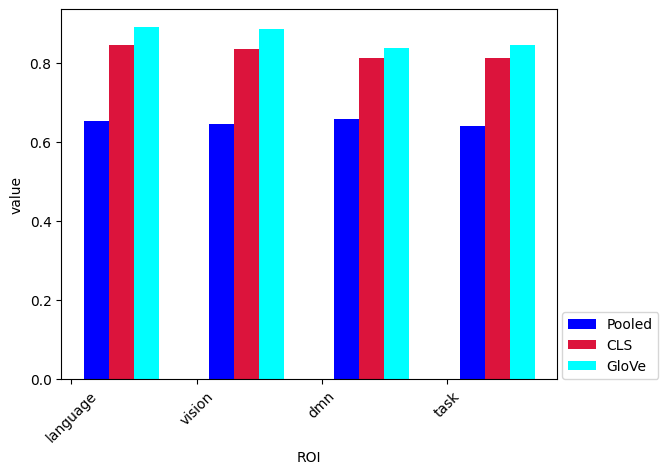

In [17]:
# Comparing the evaluation metrics using bar plots
plot_evaluation_metrics(score_dic_d_pool, score_dic_d_cls, score_dic_d_g)

### Pearson correlation

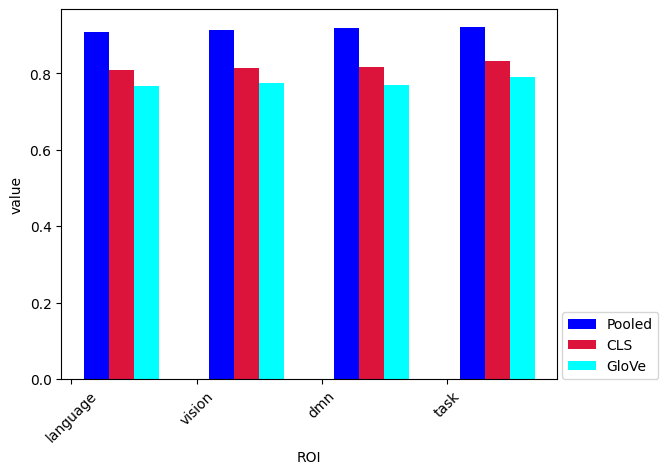

In [18]:
# Comparing the evaluation metrics using bar plots
plot_evaluation_metrics(score_dic_d_p_pool, score_dic_d_p_cls, score_dic_d_p_g)

## Subject 2 : Decoding

### 2v2 Accuracy

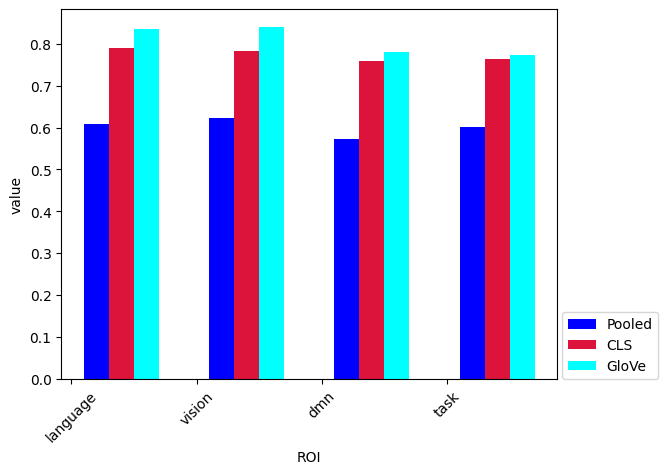

In [19]:
# Comparing the evaluation metrics using bar plots
plot_evaluation_metrics(score_dic_d2_pool, score_dic_d2_cls, score_dic_d2_g)

### Pearson correlation

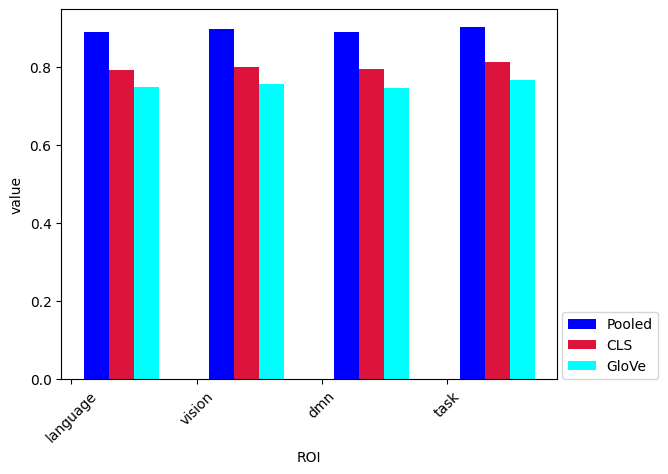

In [20]:
# Comparing the evaluation metrics using bar plots
plot_evaluation_metrics(score_dic_d2_p_pool, score_dic_d2_p_cls, score_dic_d2_p_g)

## Subject 1 : Encoding 

### 2v2 Accuracy

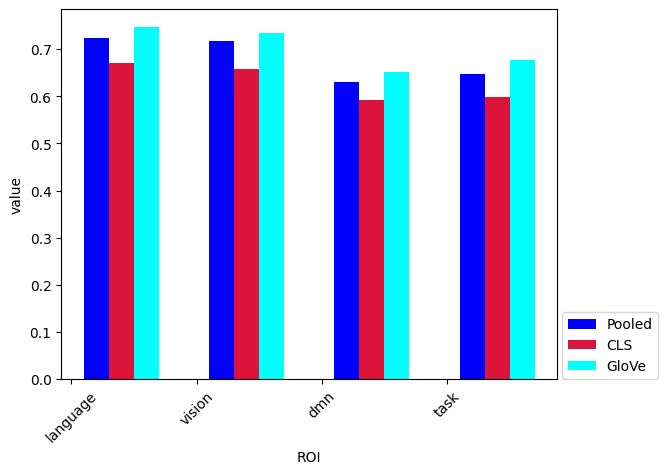

In [21]:
# Comparing the evaluation metrics using bar plots
plot_evaluation_metrics(score_dic_e_pool, score_dic_e_cls, score_dic_e_g)

### Pearson correlation

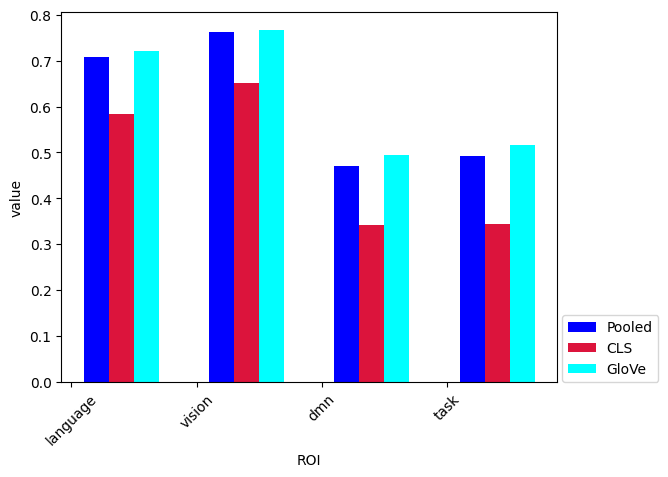

In [22]:
# Comparing the evaluation metrics using bar plots
plot_evaluation_metrics(score_dic_e_p_pool, score_dic_e_p_cls, score_dic_e_p_g)

## Subject 2 : Encoding

### 2v2 Accuracy

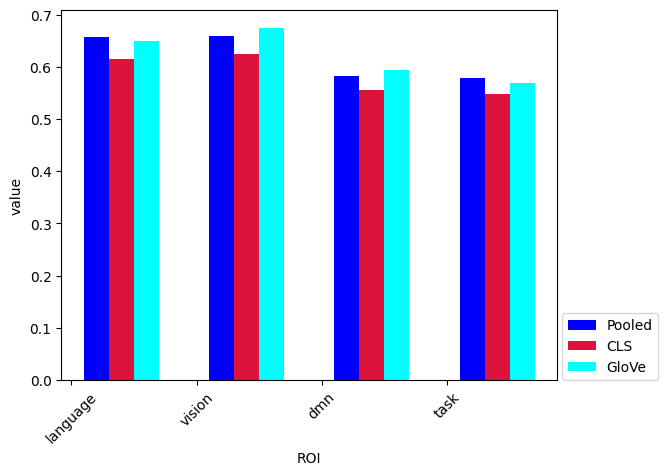

In [23]:
# Comparing the evaluation metrics using bar plots
plot_evaluation_metrics(score_dic_e2_pool, score_dic_e2_cls, score_dic_e2_g)

### Pearson correlation

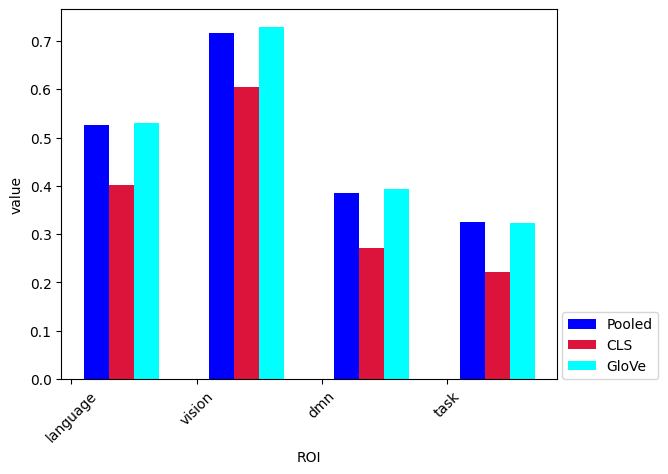

In [24]:
# Comparing the evaluation metrics using bar plots
plot_evaluation_metrics(score_dic_e2_p_pool, score_dic_e2_p_cls, score_dic_e2_p_g)